In [1]:
from __future__ import print_function
from __future__ import division

import sys
import os
qprc_path = os.path.abspath(os.path.join('..'))
if qprc_path not in sys.path:
    sys.path.append(qprc_path)
    
from utils.plots import plot_decision_function_kernel, plot_decision_function
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from  kernelfuzzy.fuzzyset import FuzzySet
from  kernelfuzzy.fuzzification import FuzzyData
from kernelfuzzy.kernels import gram_matrix_KBF_kernel,KBFkernel
from sklearn.datasets.samples_generator import make_classification
from sklearn.datasets import make_moons, make_circles,make_blobs,load_digits
from sklearn.svm import SVC,NuSVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

# Training a Non-singleton Fuzzy System with SVM and KBF kernel

This notebook shows how to train a Nonsingleton fuzzy system using regularized kernel methods with the KBF kernel

## A dataset
We create a dataset and implement a C-SVM with RBF Gaussian kernel

         x1        x2  y
0 -0.382891 -0.090840  1
1 -0.020962 -0.477874  1
2 -0.396116 -1.289427  0
3 -0.618130 -0.063837  1
4  0.703478 -0.187038  1


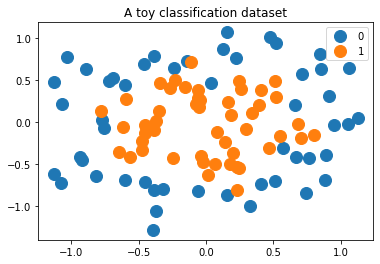

support vector indices :[ 6 20 29 43 45 48 50 55 56 58 64 76 79 82 86 87  4 12 13 21 30 31 57 62
 65 88 97]
number of support vector per class :[16 11]


//anaconda/envs/fuzzy-kernels/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



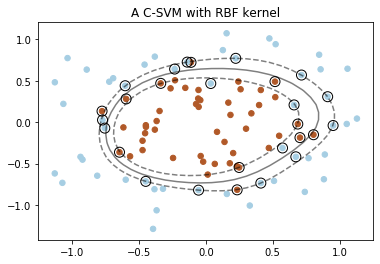

In [2]:
# we create 40 separable points
#X, y = make_blobs(n_samples=40, centers=2, random_state=6)
#X, y = make_classification(n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1)
#X, y = make_moons(noise=0.3, random_state=0)
X, y = make_circles(noise=0.2, factor=0.5, random_state=1)

df=pd.DataFrame(data=X,columns=['x1','x2'])
df['y']=y
print(df.head())

#plot the dataset
groups = df.groupby('y')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.x1, group.x2, marker='o', linestyle='', ms=12, label=name)
ax.legend()
plt.title("A toy classification dataset")
plt.show()

# A C-SVM with Gaussian RBF kernel
# fit the model, don't regularize for illustration purposes
clf = SVC(C=1000)
clf.fit(X, y)

print("support vector indices :{}".format(clf.support_))
print("number of support vector per class :{}".format(clf.n_support_))
plt.title("A C-SVM with RBF kernel")
plot_decision_function(X,y,clf)


## Non-singleton fuzzification of the dataset
In this step we perform a nonsingleton fuzzification for each value in the dataset, e.g., in row 0, the value 6.37 is transformed into a Gaussian fuzzy set with μ=6.37 and σ value. :

Heuristic for estimation of the individual $\mu_{i,d}, \sigma_{i,d}, i=1,\dots, N, d=1,\dots, D$ values for each data point: 
* $\mu_{i,d} = x_{i,d}$
* $\sigma_{i,d}\sim \mathcal{N}(\rho, \theta_{d,c})$ 

We used:
* $\theta_{d,c}=5\%* std(d,c)$ ,i.e a percentage of the std of dimension $d$ and class $c$
* $\rho \sim \mathcal{U}[std(d,c)/10, std(d,c)/2]$


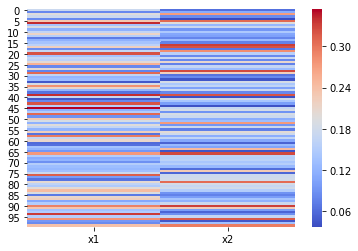

In [9]:
#nonsingleton fuzzyfication of the dataset
fuzzy_data = FuzzyData(data=df, target='y')
fuzzy_data.non_singleton_fuzzification_classification(constant_std=False,std_proportion=1)
#printing std values
ax = sns.heatmap(fuzzy_data.get_std_values(), cmap="coolwarm")

## Kernel Method learning: Training a Non-singleton FS with a C-SVM with KBF kernel


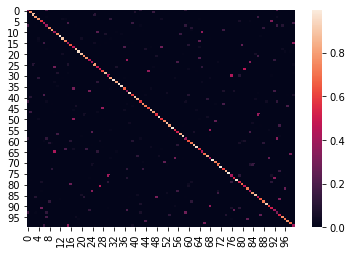

indices in training data that became rule-antecedents:[ 2  5  6 11 15 16 17 19 20 24 25 27 28 29 35 36 38 39 43 45 46 48 50 52
 53 55 56 58 60 63 64 66 68 71 74 76 79 80 81 82 83 84 86 87 90 91 94 96
 98 99  0  1  3  4  7  8  9 10 12 13 14 18 21 22 23 26 30 31 32 33 34 37
 40 41 42 44 47 49 51 54 57 59 61 62 65 67 69 70 72 73 75 77 78 85 88 89
 92 93 95 97]
number of rule-antecedents per class :[50 50]
SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='precomputed', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
(100, 2)


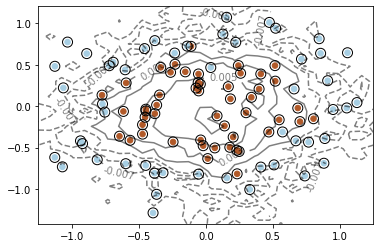

In [4]:
#computing the kernel matrix
X_train = fuzzy_data.get_fuzzydata()
y_train = fuzzy_data.get_target()

K = gram_matrix_KBF_kernel(X_train, X_train, 10)
sns.heatmap(K)
plt.show()

#training with a C-SVM
svc_p = SVC(kernel='precomputed',C=0.01)
svc_p.fit(K,y_train)

print("indices in training data that became rule-antecedents:{}".format(svc_p.support_))
print("number of rule-antecedents per class :{}".format(svc_p.n_support_))
#print("support vectors class 0 :{}".format(clf.support_vectors_[:, 0]))
#print("support vectors class 1 :{}".format(clf.support_vectors_[:, 1]))
#print("dual coefficients : {}".format(svc_p.dual_coef_))

print(svc_p)

print(fuzzy_data.get_data().to_numpy()[:,:-1].shape)
#print(fuzzy_data.get_data().to_numpy()[:,:-1])
plot_decision_function_kernel(X,X_train,y_train,svc_p)


## Kernel Method learning: Training a Non-singleton FS with a nu-SVM with KBF kernel

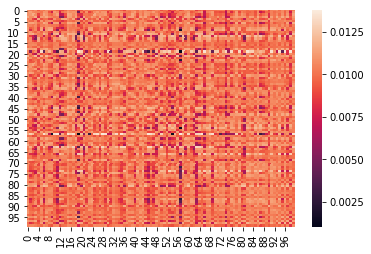

indices in training data that became rule-antecedents:[ 6 11 19 45 87  3 13 18 51 62 65]
number of rule-antecedents per class :[5 6]
NuSVC(cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
      kernel='precomputed', max_iter=-1, nu=0.1, probability=False,
      random_state=None, shrinking=True, tol=0.001, verbose=False)
(100, 2)


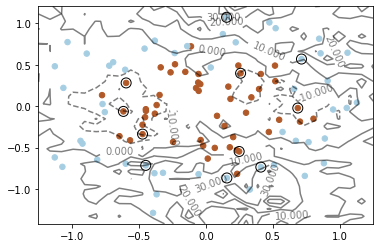

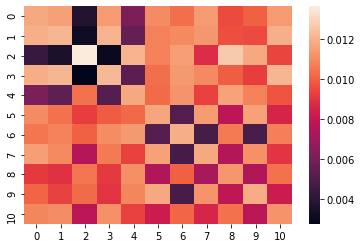

In [5]:
#computing the kernel matrix
X_train = fuzzy_data.get_fuzzydata()
y_train = fuzzy_data.get_target()

K = gram_matrix_KBF_kernel(X_train, X_train, 0.01)
sns.heatmap(K)
plt.show()

#training with a C-SVM
svc_p = NuSVC(kernel='precomputed',nu=0.1)
svc_p.fit(K,y_train)

print("indices in training data that became rule-antecedents:{}".format(svc_p.support_))
print("number of rule-antecedents per class :{}".format(svc_p.n_support_))
#print("support vectors class 0 :{}".format(clf.support_vectors_[:, 0]))
#print("support vectors class 1 :{}".format(clf.support_vectors_[:, 1]))
#print("dual coefficients : {}".format(svc_p.dual_coef_))

print(svc_p)

print(fuzzy_data.get_data().to_numpy()[:,:-1].shape)
#print(fuzzy_data.get_data().to_numpy()[:,:-1])
plot_decision_function_kernel(X,X_train,y_train,svc_p)

#plot kernel matrix with only the support vectors
sns.heatmap(K[svc_p.support_[:,None], svc_p.support_[None,:]])
plt.show()


## Setting the fuzzy rule-antecedents

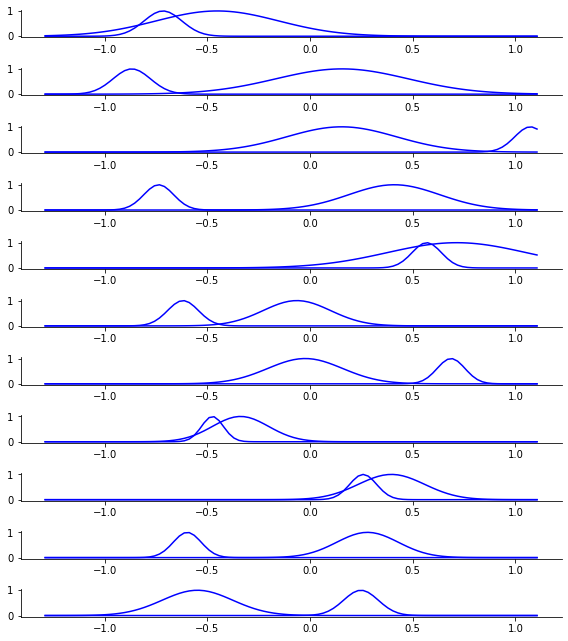

In [6]:
#fuzzy rules
M=np.sum(svc_p.n_support_) #number of rules
rules_antecedents=X_train[svc_p.support_,:]

elems=np.arange(np.min(X),np.max(X), (np.max(X)-np.min(X))/100)

fig, list_axes = plt.subplots(nrows=M, figsize=(8, 9))
i=0
for row in rules_antecedents:
    for val in row:
        mu,sigma=val.get_membership_function_params()
        list_axes[i].plot(elems,np.exp(-0.5*np.square(elems - mu)/sigma**2), 'b', linewidth=1.5)
    i=i+1
    
for ax in list_axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()


## Kernel Method learning: Training a Non-singleton FS with a nu-SVM with KBF kernel and  cross-validation

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:   26.6s finished


{'KBF__KBF_param': 1.0, 'svm__kernel': 'precomputed', 'svm__nu': 0.8}
[ 2  5  6 11 15 17 19 20 24 27 28 29 35 36 38 39 43 45 48 50 52 53 55 56
 58 60 63 64 66 68 74 76 79 80 81 82 83 84 86 87 90 91 96 99  3  4  8  9
 10 12 13 14 18 21 22 23 26 30 31 34 40 41 42 44 47 49 51 54 57 59 61 62
 65 69 70 72 73 75 78 85 88 89 92 93 95 97]
[44 42]
[[-2.05594741 -2.05594741 -0.63191374 -1.37919741 -2.05594741 -2.05594741
  -1.73133352 -2.05594741 -2.05594741 -2.05594741 -2.05594741 -2.05594741
  -2.05594741 -2.05594741 -2.05594741 -2.05594741 -2.05594741 -2.05594741
  -2.05594741 -2.05594741 -0.77610791 -0.63824529 -2.05594741 -2.05594741
  -2.05594741 -2.05594741 -1.53332361 -2.05594741 -2.05594741 -2.05594741
  -2.05594741 -2.05594741 -2.05594741 -2.05594741 -0.74516215 -2.05594741
  -2.05594741 -2.02854708 -2.05594741 -2.05594741 -1.47028733 -2.05594741
  -1.4015664  -2.05594741  2.05594741  2.05594741  2.05594741  2.05594741
   2.05594741  2.05594741  2.05594741  2.05594741  2.05594741  2.05

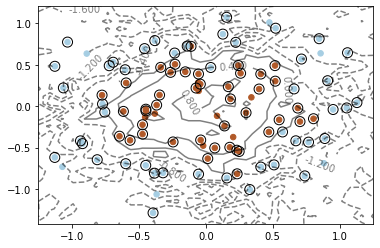

In [7]:
X_train = fuzzy_data.get_fuzzydata()
y_train = fuzzy_data.get_target()

#pipe
#nuParam=0.1
pipe = Pipeline([
    ('KBF', KBFkernel()),
    ('svm', NuSVC())])

#grid search over KBF kernel parameter   
cv_params = dict([
    ('KBF__KBF_param', 10.0**np.arange(-9,3)),
    ('svm__nu', np.arange(0.1,1,0.1)),
    ('svm__kernel', ['precomputed'])
    # ('svm__C', 10.0**np.arange(-3,3)),
])

model = GridSearchCV(pipe, cv_params, cv=5, verbose=1, n_jobs=-1)
model.fit(X_train, y_train)
    
#training the model with the best parameters
print(model.best_params_)
best_params=model.best_params_
    
#clf = SVC(kernel='precomputed',C=best_params['svm__C'])
clf = NuSVC(kernel='precomputed',nu=best_params['svm__nu'])
K = gram_matrix_KBF_kernel(X_train, X_train, best_params['KBF__KBF_param'])
clf.fit(K, y_train)

print(clf.support_)
print(clf.n_support_)
print(clf.dual_coef_)
print(clf)

print(fuzzy_data.get_data().to_numpy()[:,:-1].shape)
plot_decision_function_kernel(X,X_train,y_train,clf)

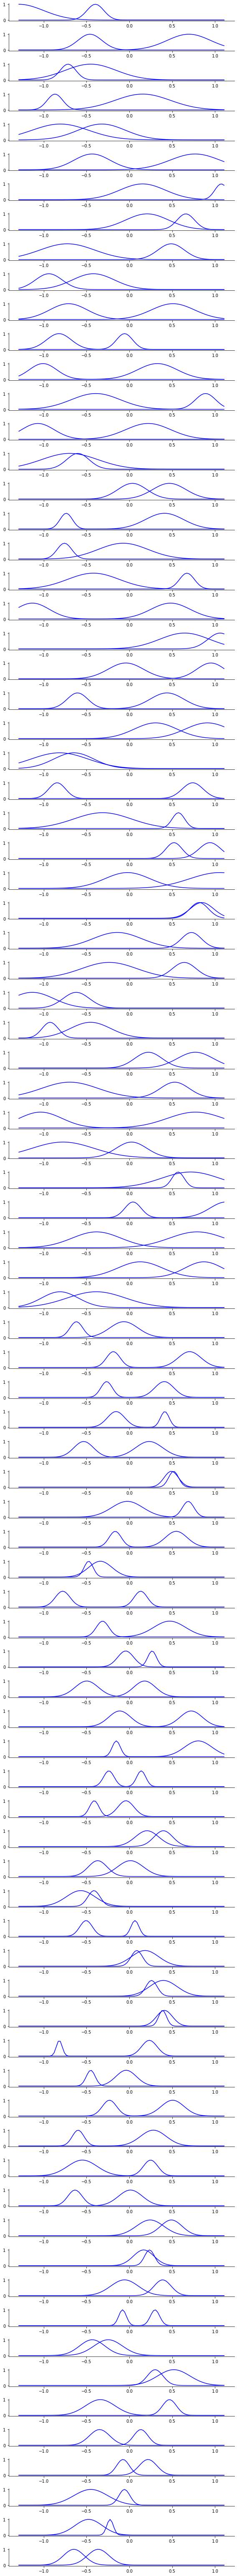

In [8]:
svc_p=clf
#fuzzy rules
M=np.sum(svc_p.n_support_) #number of rules
rules_antecedents=X_train[svc_p.support_,:]

elems=np.arange(np.min(X),np.max(X), (np.max(X)-np.min(X))/100)

fig, list_axes = plt.subplots(nrows=M, figsize=(8, M))
i=0
for row in rules_antecedents:
    for val in row:
        mu,sigma=val.get_membership_function_params()
        list_axes[i].plot(elems,np.exp(-0.5*np.square(elems - mu)/sigma**2), 'b', linewidth=1.5)
    i=i+1
    
for ax in list_axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()
